In [1]:
#notebook in full screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import os

#if we need to read the image from a ZIP file:
import zipfile
import nrrd

#TensorFlow:
import tensorflow as tf
from tensorflow import keras
##check for GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#tqdm (tune the verbose)
from tqdm.keras import TqdmCallback
#tensorflow addons:
import tensorflow_addons as tfa

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3120261049939984318
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12127040301595700841
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7046801664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3653860738700450165
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15580141694552630830
physical_device_desc: "device: XLA_GPU device"
]


# Loading the data:

In [2]:
#load data:
normalized_test_inputs = np.load('preprocessed_numpy_arrays/not_shuffled_normalized_test_inputs.npy')

# Load the model:

In [3]:
def softDiceAndBinCrossEntropy_loss(y_true, y_pred):
    ###################################################y_true = tf.dtypes.cast(y_true, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    softDice = (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)
    #we do 1-softDice since we minimize the loss but softDice need to be maximized
    softDice_loss = 1. - softDice
    
    bce = tf.keras.losses.BinaryCrossentropy()

    return (softDice_loss+bce(y_true, y_pred))/2.



def softIoU(y_true, y_pred):
    ###################################################y_true = tf.dtypes.cast(y_true, tf.float32)
    numerator = tf.reduce_sum(tf.math.multiply(y_true, y_pred))
    denominator = tf.reduce_sum(tf.math.subtract(tf.math.add(y_true, y_pred), tf.math.multiply(y_true, y_pred)))
    return tf.math.divide(numerator, denominator)

In [4]:
#load the trained model:
model = tf.keras.models.load_model('saved_model/models_combined_UNET_lossDiceAndBinCrossEntr_metricIoU_dropLayers_dataAugmentFull_40EPOCH', custom_objects={'softIoU':softIoU, 'softDiceAndBinCrossEntropy_loss':softDiceAndBinCrossEntropy_loss})

# Do prediction:

In [5]:
result = np.zeros(normalized_test_inputs.shape)
result.shape

(332, 512, 512, 1)

In [6]:
for sliceIndex in np.arange(0, result.shape[0]):#iterate throught all slices and add their prediction to the result 3D array
    tmpPrediction = model.predict(tf.convert_to_tensor([normalized_test_inputs[sliceIndex]], dtype=tf.float64)).round()
    result[sliceIndex]=tmpPrediction[0]
    print(str(sliceIndex+1)+"th slice over "+str(result.shape[0]-2)+" slices")

1th slice over 330 slices
2th slice over 330 slices
3th slice over 330 slices
4th slice over 330 slices
5th slice over 330 slices
6th slice over 330 slices
7th slice over 330 slices
8th slice over 330 slices
9th slice over 330 slices
10th slice over 330 slices
11th slice over 330 slices
12th slice over 330 slices
13th slice over 330 slices
14th slice over 330 slices
15th slice over 330 slices
16th slice over 330 slices
17th slice over 330 slices
18th slice over 330 slices
19th slice over 330 slices
20th slice over 330 slices
21th slice over 330 slices
22th slice over 330 slices
23th slice over 330 slices
24th slice over 330 slices
25th slice over 330 slices
26th slice over 330 slices
27th slice over 330 slices
28th slice over 330 slices
29th slice over 330 slices
30th slice over 330 slices
31th slice over 330 slices
32th slice over 330 slices
33th slice over 330 slices
34th slice over 330 slices
35th slice over 330 slices
36th slice over 330 slices
37th slice over 330 slices
38th slice

298th slice over 330 slices
299th slice over 330 slices
300th slice over 330 slices
301th slice over 330 slices
302th slice over 330 slices
303th slice over 330 slices
304th slice over 330 slices
305th slice over 330 slices
306th slice over 330 slices
307th slice over 330 slices
308th slice over 330 slices
309th slice over 330 slices
310th slice over 330 slices
311th slice over 330 slices
312th slice over 330 slices
313th slice over 330 slices
314th slice over 330 slices
315th slice over 330 slices
316th slice over 330 slices
317th slice over 330 slices
318th slice over 330 slices
319th slice over 330 slices
320th slice over 330 slices
321th slice over 330 slices
322th slice over 330 slices
323th slice over 330 slices
324th slice over 330 slices
325th slice over 330 slices
326th slice over 330 slices
327th slice over 330 slices
328th slice over 330 slices
329th slice over 330 slices
330th slice over 330 slices
331th slice over 330 slices
332th slice over 330 slices


In [7]:
result = result.reshape(normalized_test_inputs.shape[:-1]).astype(bool).astype(int)#gives desired final shape & 0,1 values

# Quick visualization:

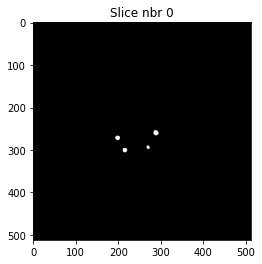

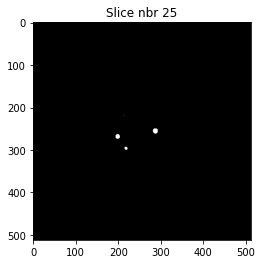

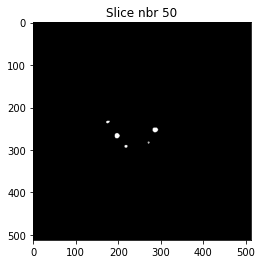

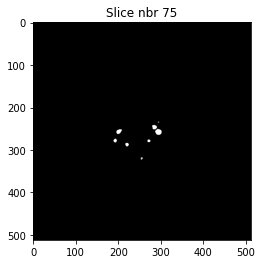

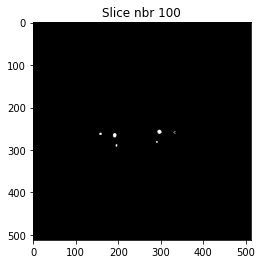

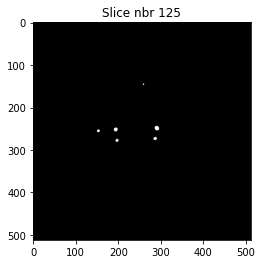

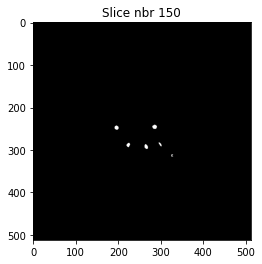

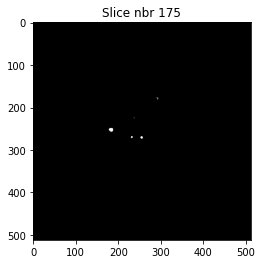

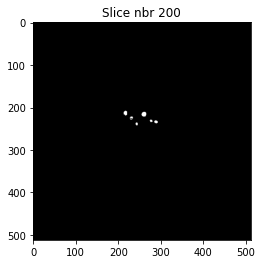

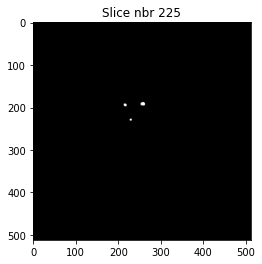

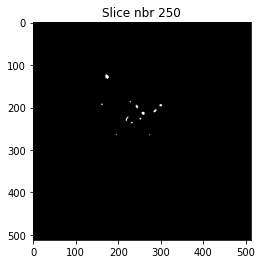

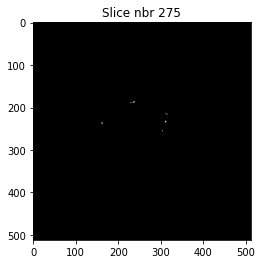

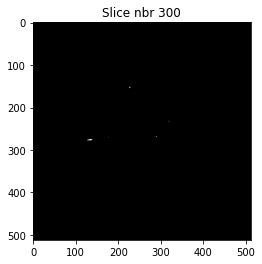

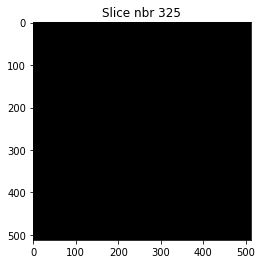

In [8]:
for sliceIndex in np.arange(0, result.shape[0], 25):
    plt.title('Slice nbr '+str(sliceIndex))
    plt.imshow(result[sliceIndex], cmap="gray") 
    plt.show() 

# Save prediction:

In [10]:
nrrd.write('predictions/predictedMask_2D.nrrd', result, index_order="C")